# Rice pan genome exploration
This notebook contains a preliminary analysis of the rice pan genome published by [Zhao et al (2018)](https://www.nature.com/articles/s41588-018-0041-z).  
The analysis is performed on a csv table detailing absence/presence of genes in each of the 67 rice lines in this publication.
The main goal was to observe how many genomes are actually needed to reach saturation in pan genome gene content.

In [47]:
library(data.table)
library(ggplot2)
#library(gdata)
library(devtools)  ## To download "stratified"


DATA_PATH <- "../data"
R_PATH <- "../R"
FIGS_PATH <- "../figs"
OUT_PATH <- "../output"

source(file.path(R_PATH, "stepwise_analysis.R"))
source_gist("https://gist.github.com/mrdwab/6424112", filename = "stratified.R")

Sourcing https://gist.githubusercontent.com/mrdwab/6424112/raw/09eabaab7896db4834d9d49bec105ce680c01439/stratified.R
SHA-1 hash of file is 8dbe107b0f29f34e58178a2b8eb60f169eabf817


## Get and process data

In [2]:
# download original data
source_url <- "http://202.127.18.228/RicePanGenome/data/Totall-42580-Genes-core-pan.xlsx"
system(paste("wget", source_url, "-P", DATA_PATH), intern=T)

character(0)

In [3]:
# Convert to csv
orig_xlsx <- file.path(DATA_PATH,"Totall-42580-Genes-core-pan.xlsx")
orig_csv_convert <- file.path(OUT_PATH,"Totall-42580-Genes-core-pan.csv")
#gdata(...)

In [4]:
# read csv
orig_table <- fread(orig_csv_convert, head = T, sep = ',')

Read 42581 rows and 70 (of 70) columns from 0.049 GB file in 00:00:11


In [5]:
# extract just lines and genes
PAV_table <- orig_table[-1,-c(1,2,70)]
# convert cells with spaces to NA
PAV_table <- as.data.frame( apply(PAV_table, 2, function(x) gsub("^$|^ $", NA, x)) , stringsAsFactors = F)
# convert pan gene names to TRUE (presence) and NAs to FALSE (absence)
PAV_table <- as.data.frame( !is.na(PAV_table) )

In [6]:
head(PAV_table)

GLA4 GP3  GP22 GP51 GP72 GP772-1 HP119 HP263 HP274 HP327 ... W1687 W1698
1 TRUE TRUE TRUE TRUE TRUE TRUE    TRUE  TRUE  TRUE  TRUE  ... TRUE  TRUE 
2 TRUE TRUE TRUE TRUE TRUE TRUE    TRUE  TRUE  TRUE  TRUE  ... TRUE  TRUE 
3 TRUE TRUE TRUE TRUE TRUE TRUE    TRUE  TRUE  TRUE  TRUE  ... TRUE  TRUE 
4 TRUE TRUE TRUE TRUE TRUE TRUE    TRUE  TRUE  TRUE  TRUE  ... TRUE  TRUE 
5 TRUE TRUE TRUE TRUE TRUE TRUE    TRUE  TRUE  TRUE  TRUE  ... TRUE  TRUE 
6 TRUE TRUE TRUE TRUE TRUE TRUE    TRUE  TRUE  TRUE  TRUE  ... TRUE  TRUE 
  W1739 W1754 W1777 W1943 W1979 W2012 W3078-2 W3095-2
1 TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE    TRUE   
2 TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE    TRUE   
3 TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE    TRUE   
4 TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE    TRUE   
5 TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE    TRUE   
6 TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE    TRUE

In [52]:
# keep aside the affiliation of each line to rice group
line_group <- t(orig_table[1,-c(1,2,70)])
line_group <- data.frame(line = rownames(line_group), group = line_group)
head(line_group)

line    group           
GLA4    GLA4    O. sativa indica
GP3     GP3     O. sativa indica
GP22    GP22    O. sativa indica
GP51    GP51    O. sativa indica
GP72    GP72    O. sativa indica
GP772-1 GP772-1 O. sativa indica

In [8]:
# also keep aside a table of pan genes and their counts (in how many lines they are present)
pan_genes_table <- orig_table[-1,c(2,70)]
head(pan_genes_table)

MSU              Count
1 LOC_Os10g30840.1 67   
2 LOC_Os03g31280.1 67   
3 LOC_Os07g13090.1 67   
4 LOC_Os04g27760.1 67   
5 LOC_Os04g02570.1 67   
6 LOC_Os08g17770.1 67

## Analysis
A stepwise approach, similar to the one described in the paper, is used for adding more and more genomes into the pan genes set. In each step, the number of lines involved and the cumulative number of pan genes are recorded.

### Analyze all lines and all genes
Start by analyzing all 67 lines without filtering any pan genes.
Line order is randomized multiple times.

In [18]:
## analyze all 67 lines
line_names <- colnames(PAV_table)
# number of times to randomize order of lines
N = 100
all_lines_all_genes_res <- iterate_stepwise_analysis(PAV_table, line_names, N)

In [19]:
# summarize result to get means and SEs
all_lines_all_genes_res_sum <- summarySE(all_lines_all_genes_res, measurevar = "n_genes_vec",
                                 groupvars = "n_lines_vec")
head(all_lines_all_genes_res_sum)

n_lines_vec N   n_genes_vec sd       se       ci       
1 1           100 30922.76    628.3735 62.83735 124.68293
2 2           100 33338.24    542.8876 54.28876 107.72067
3 3           100 34483.35    481.9923 48.19923  95.63773
4 4           100 35112.89    485.8436 48.58436  96.40190
5 5           100 35658.55    441.9239 44.19239  87.68729
6 6           100 36100.87    458.7441 45.87441  91.02479

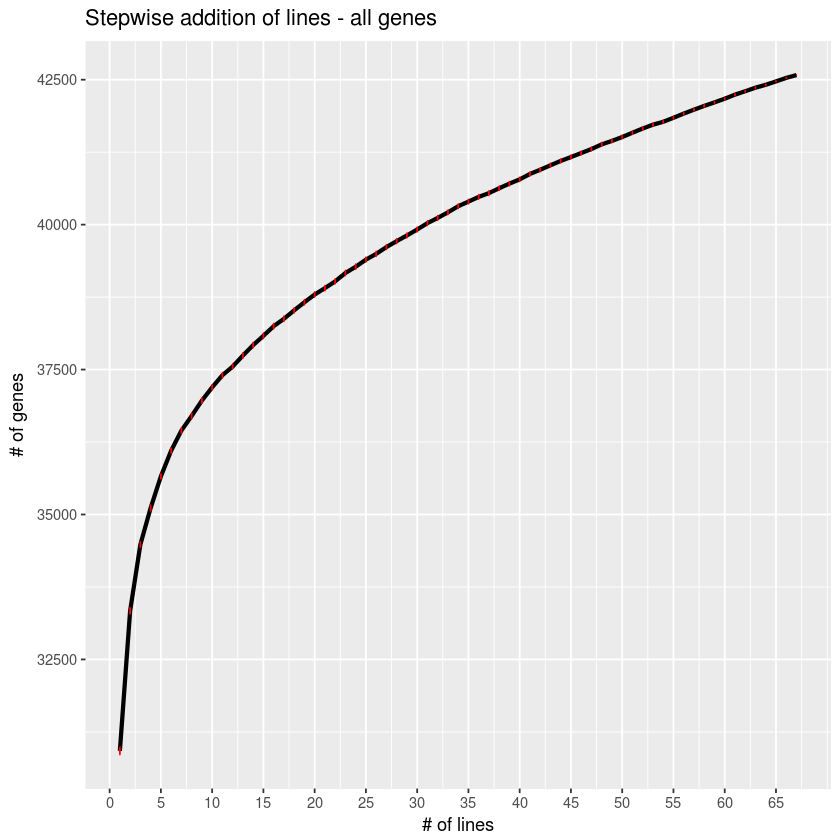

In [28]:
(plot_all_lines_all_genes <- ggplot(all_lines_all_genes_res_sum, aes(x=n_lines_vec, y=n_genes_vec))
    + geom_line(size=1.2)
    + labs(x = "# of lines", y = "# of genes", title = "Stepwise addition of lines - all genes")
    + geom_errorbar(aes(ymin=n_genes_vec-se, ymax=n_genes_vec+se), width=.1, color = 'red')
    + scale_x_continuous(breaks = seq(0,67,5))
    )

We observe:
- That SEs are very small and therefor they won't be plotted in next plots
- Looks like slope at 67 is rather linear, so gene pool is not saturated.

### Analyze filtered gene sets
We suspect that the pan genome doesn't get saturated because of singletons - pan genes that appear in only one rice line and are possibly artifacts resulting from annotation errors.
Therefore, we repeat the stepwise analysis for two filtered sets of genes:
- Singletons discarded
- High-confidence genes only - those that appear in at least 5 lines

In [32]:
# filter out singletons
PAV_table_no_singletons <- PAV_table[which(pan_genes_table$Count > 2),]
# only take high conf genes
PAV_table_high_conf <- PAV_table[which(pan_genes_table$Count >= 5),]

In [34]:
# run stepwise analysis
all_lines_no_singletons_res <- iterate_stepwise_analysis(PAV_table_no_singletons, line_names, N)
all_lines_high_conf_res <- iterate_stepwise_analysis(PAV_table_high_conf, line_names, N)

In [35]:
# combine results for all genes, no singletons and high conf into one table with a column indicating the genes set
all_lines_all_genes_res$genes_set <- rep("all genes",nrow(all_lines_all_genes_res))
all_lines_no_singletons_res$genes_set <- rep("no singletons",nrow(all_lines_no_singletons_res))
all_lines_high_conf_res$genes_set <- rep("high conf.",nrow(all_lines_high_conf_res))
all_lines_comb_res <- rbind(all_lines_all_genes_res, all_lines_no_singletons_res, all_lines_high_conf_res)
# summarize combined result
all_lines_comb_res_sum <- summarySE(all_lines_comb_res, measurevar = "n_genes_vec",
                                 groupvars = c("n_lines_vec", "genes_set"))

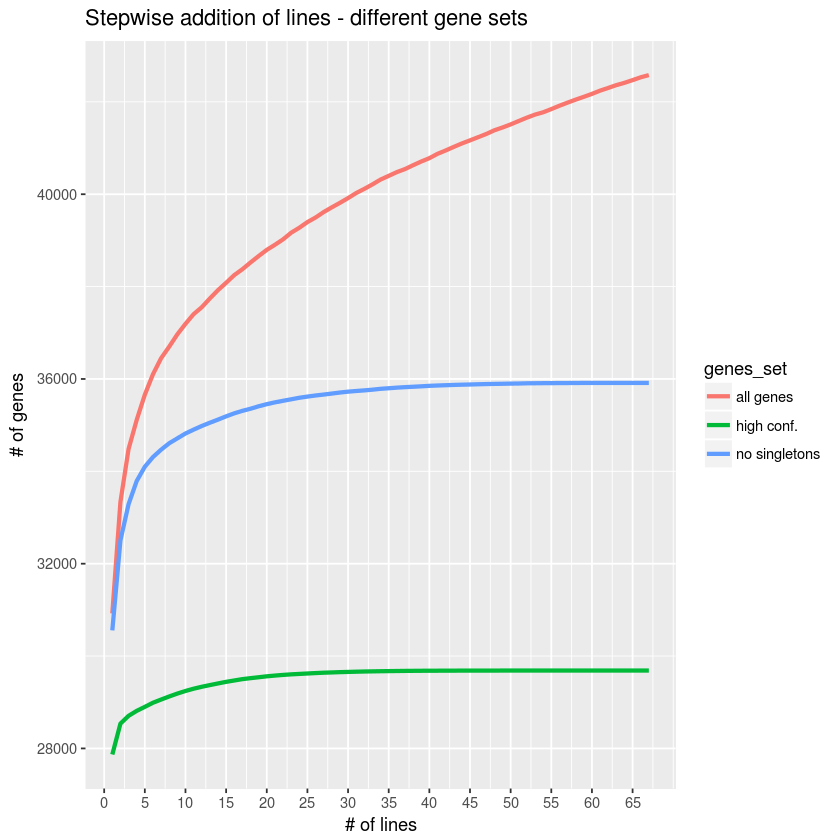

In [37]:
# plot
(plot_all_lines_comb <- ggplot(all_lines_comb_res_sum, aes(x=n_lines_vec, y=n_genes_vec, color=genes_set))
    + geom_line(size=1.2)
    + labs(x = "# of lines", y = "# of genes", title = "Stepwise addition of lines - different gene sets")
    + scale_x_continuous(breaks = seq(0,67,5))
    )

Indeed, when singletons are removed the pan genome reaches a plateau. This happens at ~25 lines for high conf. genes set and ~40 lines when singletons are removed.
Subsequent analyses will be performed on the 'high conf.' set.

### How many lines are required to saturate the pan genome?
We wanted to check whether (most of) the gene content of the pan genome can be covered with less lines. To test this, the following analyses are performed:
- See how well gene content is covered when only one line per rice group (total 6 rice groups) is taken.
- For contraol, 6 random lines will be tested too.
- Get the optimal order of lines to cover as musch gene conetent.

In [58]:
# random 6 lines - randomly choose sets of 6 lines 10 times (i), and randomize their order 10 times (N)
N <- 10
random_6_lines_high_conf_res <- data.frame(n_lines_vec = c(), n_genes_vec <- c())
for (i in 1:10){
    random_6_lines <- sample(colnames(PAV_table_high_conf), 6)
    random_6_lines_high_conf_res <- rbind(random_6_lines_high_conf_res, iterate_stepwise_analysis(PAV_table_high_conf, random_6_lines, N))
}
random_6_lines_high_conf_res$analysis <- rep("random 6 lines", nrow(random_6_lines_high_conf_res))

In [59]:
# one line per group - randomly choose sets of representative lines 10 times (i), and randomize their order 10 times (N)
N <- 10
represent_6_lines_high_conf_res <- data.frame(n_lines_vec = c(), n_genes_vec <- c())
for (i in 1:10){
    represent_6_lines <- stratified(line_group, "group", 1)$line
    represent_6_lines_high_conf_res <- rbind(represent_6_lines_high_conf_res, iterate_stepwise_analysis(PAV_table_high_conf, represent_6_lines, N))
}
represent_6_lines_high_conf_res$analysis <- rep("Representative lines", nrow(represent_6_lines_high_conf_res))

In [61]:
# combine and summarize
all_lines_high_conf_res <- all_lines_high_conf_res[,-3]
all_lines_high_conf_res$analysis <- rep("All lines",nrow(all_lines_high_conf_res))
high_conf_comb_res <- rbind(all_lines_high_conf_res, random_6_lines_high_conf_res, represent_6_lines_high_conf_res)
high_conf_comb_res_sum <- summarySE(high_conf_comb_res, measurevar = "n_genes_vec",
                                 groupvars = c("n_lines_vec", "analysis"))

Warning message:
“Removed 42 rows containing missing values (geom_path).”

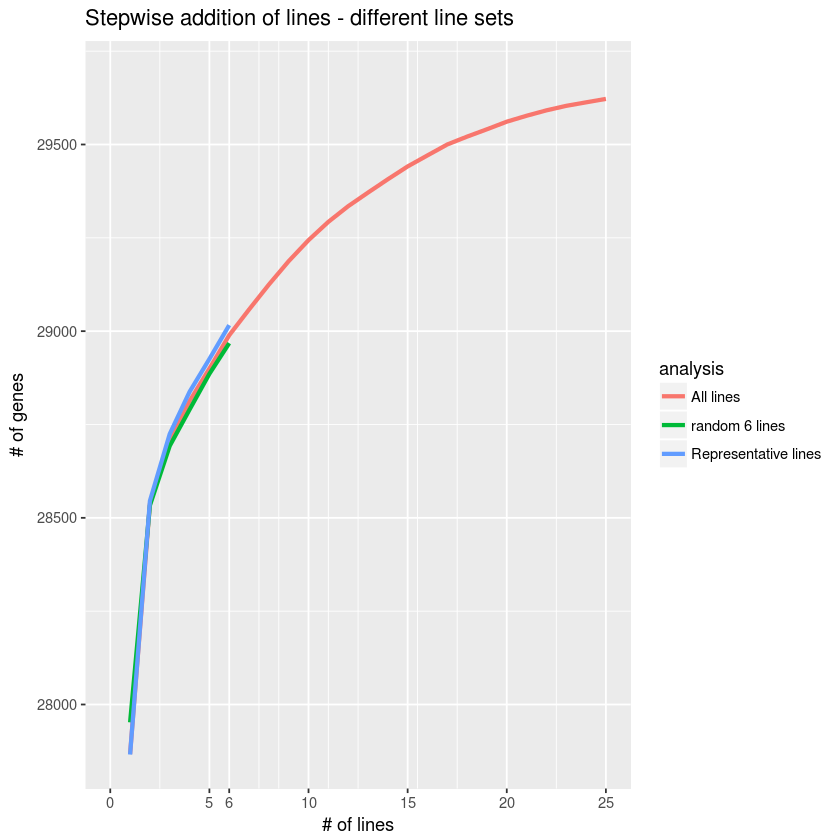

In [67]:
# plot
(plot_high_conf_comb <- ggplot(high_conf_comb_res_sum, aes(x=n_lines_vec, y=n_genes_vec, color=analysis))
    + geom_line(size=1.2)
    + labs(x = "# of lines", y = "# of genes", title = "Stepwise addition of lines - different line sets")
    + scale_x_continuous(breaks = c(seq(0,67,5),c(6)), limits = c(0,25))
    )

Selecting one line per group does only slightly better than random lines, and covers only part of the gene content.
Let's see if choosing the optimal order of lines can do better. The optimal order is estimated with a greedy algorithm that adds lines one by one, so at each step the largest pan genes set is acquired.

In [76]:
# get list of gene sets per line
gene_sets <- lapply(PAV_table_high_conf,function(x){return(rownames(PAV_table_high_conf)[x])})

greedy_find_next_line <- function(s1){
    # given a set of genes, find the next line to add
    # in order to get the largest union (greedy)
    unions <- lapply(gene_sets,function(x){return(length(union(s1,x)))})
    return(which.max(unlist(unions)))
}

# greedy find best order
# start from line with most genes
pan_genes_set <- c()
best_lines_order <- c()
i <- 1
while (i <= ncol(PAV_table_high_conf)){
    next_line <- greedy_find_next_line(pan_genes_set)
    pan_genes_set <- union(pan_genes_set,gene_sets[next_line][[1]])
    best_lines_order <- c(best_lines_order, next_line)
    i <- i + 1
}

In [77]:
print(best_lines_order)

Nipponbare      W1739      W1979       GP62      W1687      W0170    W3095-2 
        20         60         64         52         58         57         67 
      GP51      W1777      HP492      GP124       GP39      HP383       HP44 
         4         62         16         50         43         12         28 
     HP396       DHX2    GP295-1      W1698       HP14      HP274      W1943 
        13         38         48         59         26          9         63 
      GP72    HP362-2      GP669      HP407       GLA4       GLA4       GLA4 
         5         11         23         14          1          1          1 
      GLA4       GLA4       GLA4       GLA4       GLA4       GLA4       GLA4 
         1          1          1          1          1          1          1 
      GLA4       GLA4       GLA4       GLA4       GLA4       GLA4       GLA4 
         1          1          1          1          1          1          1 
      GLA4       GLA4       GLA4       GLA4       GLA4       GLA

In [82]:
# step wise analysis (no need to iterate since order is fixed)
best_lines_high_conf_res <- get_stepwise_result(PAV_table_high_conf, best_lines_order)

In [83]:
# combine and summarize
all_lines_high_conf_res$analysis <- rep("Random order",nrow(all_lines_high_conf_res))
best_lines_high_conf_res$analysis <- rep("Optimal order",nrow(best_lines_high_conf_res))
high_conf_comb_res <- rbind(all_lines_high_conf_res, best_lines_high_conf_res)
high_conf_comb_res_sum <- summarySE(high_conf_comb_res, measurevar = "n_genes_vec",
                                 groupvars = c("n_lines_vec", "analysis"))

Warning message in qt(conf.interval/2 + 0.5, datac$N - 1):
“NaNs produced”

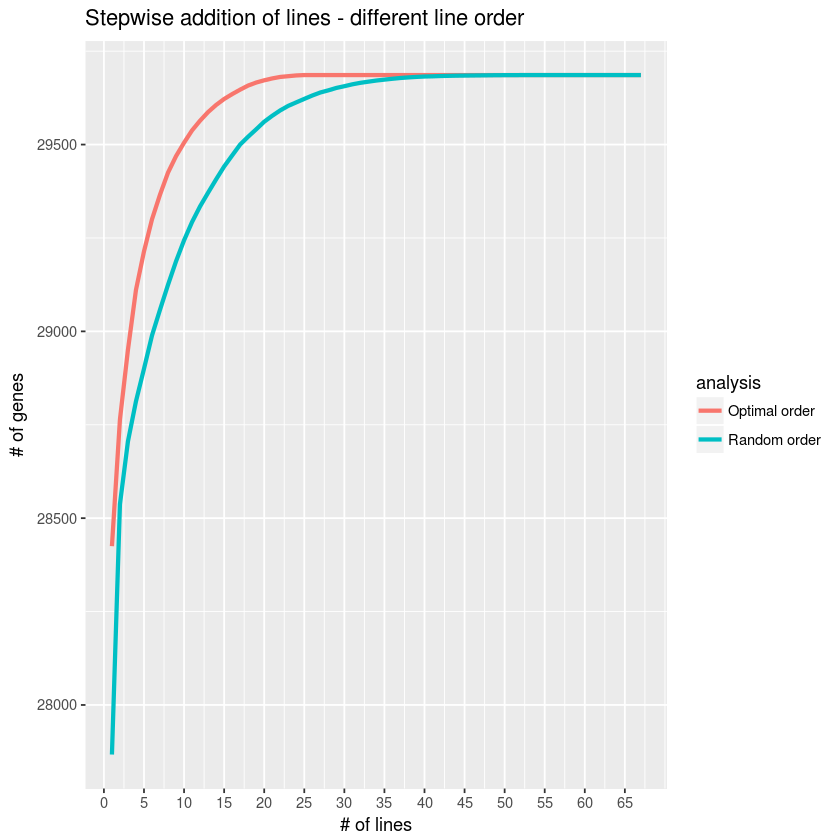

In [84]:
# plot
(plot_high_conf_comb <- ggplot(high_conf_comb_res_sum, aes(x=n_lines_vec, y=n_genes_vec, color=analysis))
    + geom_line(size=1.2)
    + labs(x = "# of lines", y = "# of genes", title = "Stepwise addition of lines - different line order")
    + scale_x_continuous(breaks = seq(0,67,5))
    )

After 26 lines, all genes have been added (that's why the 26th line is repeated again and again).
Using this optimal order gets the plot to a plateau a bit earlier. If we look at the phlogenetic tree from the publication, we can see that the first lines in the list are dispersed accross it, so there is some phylogenetic signal.
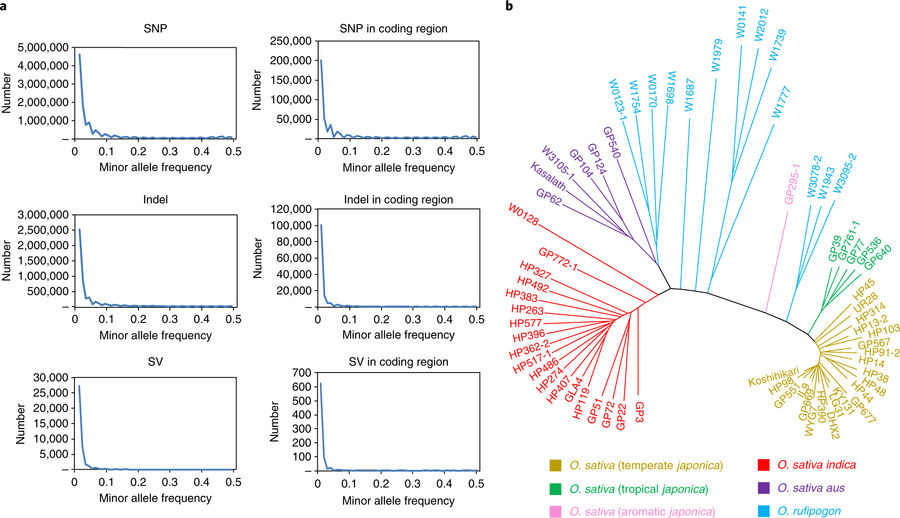![](https://www.nature.com/articles/s41588-018-0041-z/figures/1)